In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [4]:
train_dir = 'data/breakhis/train/'
test_dir = "data/breakhis/test/"

extracted_features_dir = "extracted_features/"
model_name = "breakhis_densenet"

In [5]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [6]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/breakhis/train/ 0
data/breakhis/train/benign 36224
data/breakhis/train/malignant 79168
******************************
data/breakhis/test/ 0
data/breakhis/test/benign 216
data/breakhis/test/malignant 481


In [8]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 86544 images belonging to 2 classes.
Found 28848 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [9]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 86544
nb_validation_samples: 28848

predict_size_train: 2705
predict_size_validation: 902
nb_test_samples: 697
predict_size_test: 22

 num_classes: 2


In [10]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [11]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = DenseNet201(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

690 conv5_block30_concat
691 conv5_block31_0_bn
692 conv5_block31_0_relu
693 conv5_block31_1_conv
694 conv5_block31_1_bn
695 conv5_block31_1_relu
696 conv5_block31_2_conv
697 conv5_block31_concat
698 conv5_block32_0_bn
699 conv5_block32_0_relu
700 conv5_block32_1_conv
701 conv5_block32_1_bn
702 conv5_block32_1_relu
703 conv5_block32_2_conv
704 conv5_block32_concat
705 bn
706 relu
707 avg_pool


In [13]:
c1 = model.layers[9].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[55].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[143].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[483].output
c4 = GlobalAveragePooling2D()(c4)

con = concatenate([c1, c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv4_block11_0_bn (BatchNormal (None, 14, 14, 576)  2304        conv4_block10_concat[0][0]       
__________________________________________________________________________________________________
conv4_block11_0_relu (Activatio (None, 14, 14, 576)  0           conv4_block11_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block11_1_conv (Conv2D)   (None, 14, 14, 128)  73728       conv4_block11_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block11_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block11_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block11_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block44_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block44_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block44_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block44_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block44_2_conv (Conv2D)   (None, 14, 14, 32)   36864       conv4_block44_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block44_concat (Concatena (None, 14, 14, 1664) 0           conv4_block43_concat[0][0]       
                                                                 conv4_block44_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_bloc

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [17]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 86544 samples, validate on 28848 samples
Epoch 1/1000
 - 15s - loss: 0.5882 - acc: 0.6934 - val_loss: 0.5453 - val_acc: 0.7032
Epoch 2/1000
 - 11s - loss: 0.5033 - acc: 0.7579 - val_loss: 0.4663 - val_acc: 0.8068
Epoch 3/1000
 - 11s - loss: 0.4392 - acc: 0.8081 - val_loss: 0.4150 - val_acc: 0.8212
Epoch 4/1000
 - 11s - loss: 0.4023 - acc: 0.8288 - val_loss: 0.3837 - val_acc: 0.8383
Epoch 5/1000
 - 11s - loss: 0.3754 - acc: 0.8434 - val_loss: 0.3628 - val_acc: 0.8467
Epoch 6/1000
 - 11s - loss: 0.3562 - acc: 0.8541 - val_loss: 0.3493 - val_acc: 0.8520
Epoch 7/1000
 - 11s - loss: 0.3392 - acc: 0.8619 - val_loss: 0.3289 - val_acc: 0.8688
Epoch 8/1000
 - 11s - loss: 0.3261 - acc: 0.8690 - val_loss: 0.3168 - val_acc: 0.8735
Epoch 9/1000
 - 11s - loss: 0.3149 - acc: 0.8750 - val_loss: 0.3259 - val_acc: 0.8634
Epoch 10/1000
 - 11s - loss: 0.3060 - acc: 0.8796 - val_loss: 0.3035 - val_acc: 0.8770
Epoch 11/1000
 - 11s - loss: 0.2990 - acc: 0.8821 - val_loss: 0.2917 - val_acc: 0.8859
Ep

Epoch 95/1000
 - 11s - loss: 0.1141 - acc: 0.9559 - val_loss: 0.1048 - val_acc: 0.9601
Epoch 96/1000
 - 11s - loss: 0.1144 - acc: 0.9559 - val_loss: 0.1056 - val_acc: 0.9603
Epoch 97/1000
 - 11s - loss: 0.1138 - acc: 0.9568 - val_loss: 0.1041 - val_acc: 0.9613
Epoch 98/1000
 - 11s - loss: 0.1121 - acc: 0.9571 - val_loss: 0.1020 - val_acc: 0.9625
Epoch 99/1000
 - 11s - loss: 0.1121 - acc: 0.9574 - val_loss: 0.1038 - val_acc: 0.9603
Epoch 100/1000
 - 11s - loss: 0.1111 - acc: 0.9571 - val_loss: 0.1045 - val_acc: 0.9600
Epoch 101/1000
 - 11s - loss: 0.1109 - acc: 0.9575 - val_loss: 0.1024 - val_acc: 0.9615
Epoch 102/1000
 - 11s - loss: 0.1095 - acc: 0.9581 - val_loss: 0.1028 - val_acc: 0.9613
Epoch 103/1000
 - 11s - loss: 0.1097 - acc: 0.9582 - val_loss: 0.1016 - val_acc: 0.9608
Epoch 104/1000
 - 11s - loss: 0.1081 - acc: 0.9581 - val_loss: 0.0988 - val_acc: 0.9624
Epoch 105/1000
 - 11s - loss: 0.1085 - acc: 0.9586 - val_loss: 0.1024 - val_acc: 0.9609
Epoch 106/1000
 - 11s - loss: 0.1075 

 - 11s - loss: 0.0745 - acc: 0.9722 - val_loss: 0.0661 - val_acc: 0.9756
Epoch 189/1000
 - 11s - loss: 0.0748 - acc: 0.9722 - val_loss: 0.0677 - val_acc: 0.9746
Epoch 190/1000
 - 11s - loss: 0.0750 - acc: 0.9722 - val_loss: 0.0654 - val_acc: 0.9758
Epoch 191/1000
 - 11s - loss: 0.0741 - acc: 0.9723 - val_loss: 0.0658 - val_acc: 0.9751
Epoch 192/1000
 - 11s - loss: 0.0751 - acc: 0.9720 - val_loss: 0.0668 - val_acc: 0.9747
Epoch 193/1000
 - 11s - loss: 0.0738 - acc: 0.9724 - val_loss: 0.0715 - val_acc: 0.9732
Epoch 194/1000
 - 11s - loss: 0.0751 - acc: 0.9721 - val_loss: 0.0656 - val_acc: 0.9756
Epoch 195/1000
 - 11s - loss: 0.0726 - acc: 0.9731 - val_loss: 0.0639 - val_acc: 0.9756
Epoch 196/1000
 - 11s - loss: 0.0729 - acc: 0.9723 - val_loss: 0.0657 - val_acc: 0.9760
Epoch 197/1000
 - 11s - loss: 0.0733 - acc: 0.9726 - val_loss: 0.0662 - val_acc: 0.9748
Epoch 198/1000
 - 11s - loss: 0.0724 - acc: 0.9728 - val_loss: 0.0663 - val_acc: 0.9754
Epoch 199/1000
 - 11s - loss: 0.0728 - acc: 0.9

Epoch 282/1000
 - 11s - loss: 0.0590 - acc: 0.9787 - val_loss: 0.0520 - val_acc: 0.9809
Epoch 283/1000
 - 11s - loss: 0.0588 - acc: 0.9784 - val_loss: 0.0529 - val_acc: 0.9803
Epoch 284/1000
 - 11s - loss: 0.0587 - acc: 0.9783 - val_loss: 0.0531 - val_acc: 0.9799
Epoch 285/1000
 - 11s - loss: 0.0588 - acc: 0.9784 - val_loss: 0.0577 - val_acc: 0.9786
Epoch 286/1000
 - 11s - loss: 0.0584 - acc: 0.9784 - val_loss: 0.0530 - val_acc: 0.9802
Epoch 287/1000
 - 11s - loss: 0.0579 - acc: 0.9791 - val_loss: 0.0509 - val_acc: 0.9807
Epoch 288/1000
 - 11s - loss: 0.0574 - acc: 0.9795 - val_loss: 0.0512 - val_acc: 0.9813
Epoch 289/1000
 - 11s - loss: 0.0584 - acc: 0.9788 - val_loss: 0.0498 - val_acc: 0.9815
Epoch 290/1000
 - 11s - loss: 0.0575 - acc: 0.9787 - val_loss: 0.0599 - val_acc: 0.9785
Epoch 291/1000
 - 11s - loss: 0.0584 - acc: 0.9783 - val_loss: 0.0533 - val_acc: 0.9803
Epoch 292/1000
 - 11s - loss: 0.0583 - acc: 0.9786 - val_loss: 0.0515 - val_acc: 0.9812
Epoch 293/1000
 - 11s - loss: 0.

 - 11s - loss: 0.0497 - acc: 0.9825 - val_loss: 0.0478 - val_acc: 0.9824
Epoch 376/1000
 - 11s - loss: 0.0498 - acc: 0.9818 - val_loss: 0.0412 - val_acc: 0.9855
Epoch 377/1000
 - 11s - loss: 0.0494 - acc: 0.9820 - val_loss: 0.0408 - val_acc: 0.9854
Epoch 378/1000
 - 11s - loss: 0.0495 - acc: 0.9822 - val_loss: 0.0461 - val_acc: 0.9830
Epoch 379/1000
 - 11s - loss: 0.0496 - acc: 0.9816 - val_loss: 0.0438 - val_acc: 0.9839
Epoch 380/1000
 - 11s - loss: 0.0500 - acc: 0.9818 - val_loss: 0.0411 - val_acc: 0.9850
Epoch 381/1000
 - 11s - loss: 0.0494 - acc: 0.9823 - val_loss: 0.0459 - val_acc: 0.9827
Epoch 382/1000
 - 11s - loss: 0.0499 - acc: 0.9821 - val_loss: 0.0482 - val_acc: 0.9822
Epoch 383/1000
 - 11s - loss: 0.0490 - acc: 0.9826 - val_loss: 0.0443 - val_acc: 0.9840
Epoch 384/1000
 - 11s - loss: 0.0505 - acc: 0.9820 - val_loss: 0.0426 - val_acc: 0.9847
Epoch 385/1000
 - 11s - loss: 0.0502 - acc: 0.9816 - val_loss: 0.0399 - val_acc: 0.9860
Epoch 386/1000
 - 11s - loss: 0.0487 - acc: 0.9

Epoch 469/1000
 - 11s - loss: 0.0445 - acc: 0.9847 - val_loss: 0.0387 - val_acc: 0.9858
Epoch 470/1000
 - 11s - loss: 0.0449 - acc: 0.9842 - val_loss: 0.0381 - val_acc: 0.9860
Epoch 471/1000
 - 11s - loss: 0.0443 - acc: 0.9842 - val_loss: 0.0398 - val_acc: 0.9856
Epoch 472/1000
 - 11s - loss: 0.0443 - acc: 0.9844 - val_loss: 0.0399 - val_acc: 0.9861
Epoch 473/1000
 - 11s - loss: 0.0441 - acc: 0.9845 - val_loss: 0.0389 - val_acc: 0.9855
Epoch 474/1000
 - 11s - loss: 0.0437 - acc: 0.9840 - val_loss: 0.0435 - val_acc: 0.9844
Epoch 475/1000
 - 11s - loss: 0.0452 - acc: 0.9838 - val_loss: 0.0360 - val_acc: 0.9873
Epoch 476/1000
 - 11s - loss: 0.0439 - acc: 0.9843 - val_loss: 0.0381 - val_acc: 0.9864
Epoch 477/1000
 - 11s - loss: 0.0442 - acc: 0.9844 - val_loss: 0.0476 - val_acc: 0.9835
Epoch 478/1000
 - 11s - loss: 0.0440 - acc: 0.9849 - val_loss: 0.0389 - val_acc: 0.9852
Epoch 479/1000
 - 11s - loss: 0.0450 - acc: 0.9841 - val_loss: 0.0379 - val_acc: 0.9862
Epoch 480/1000
 - 11s - loss: 0.

 - 11s - loss: 0.0421 - acc: 0.9853 - val_loss: 0.0348 - val_acc: 0.9881
Epoch 563/1000
 - 11s - loss: 0.0409 - acc: 0.9854 - val_loss: 0.0347 - val_acc: 0.9873
Epoch 564/1000
 - 11s - loss: 0.0416 - acc: 0.9851 - val_loss: 0.0415 - val_acc: 0.9856
Epoch 565/1000
 - 11s - loss: 0.0406 - acc: 0.9853 - val_loss: 0.0427 - val_acc: 0.9849
Epoch 566/1000
 - 11s - loss: 0.0406 - acc: 0.9858 - val_loss: 0.0338 - val_acc: 0.9878
Epoch 567/1000
 - 11s - loss: 0.0415 - acc: 0.9850 - val_loss: 0.0361 - val_acc: 0.9875
Epoch 568/1000
 - 11s - loss: 0.0407 - acc: 0.9859 - val_loss: 0.0344 - val_acc: 0.9877
Epoch 569/1000
 - 11s - loss: 0.0407 - acc: 0.9858 - val_loss: 0.0331 - val_acc: 0.9884
Epoch 570/1000
 - 11s - loss: 0.0418 - acc: 0.9859 - val_loss: 0.0342 - val_acc: 0.9880
Epoch 571/1000
 - 11s - loss: 0.0413 - acc: 0.9852 - val_loss: 0.0372 - val_acc: 0.9863
Epoch 572/1000
 - 11s - loss: 0.0410 - acc: 0.9860 - val_loss: 0.0333 - val_acc: 0.9887
Epoch 573/1000
 - 11s - loss: 0.0397 - acc: 0.9

Epoch 656/1000
 - 11s - loss: 0.0377 - acc: 0.9869 - val_loss: 0.0314 - val_acc: 0.9888
Epoch 657/1000
 - 11s - loss: 0.0383 - acc: 0.9866 - val_loss: 0.0333 - val_acc: 0.9889
Epoch 658/1000
 - 11s - loss: 0.0391 - acc: 0.9868 - val_loss: 0.0316 - val_acc: 0.9886
Epoch 659/1000
 - 11s - loss: 0.0383 - acc: 0.9869 - val_loss: 0.0351 - val_acc: 0.9880
Epoch 660/1000
 - 11s - loss: 0.0390 - acc: 0.9864 - val_loss: 0.0335 - val_acc: 0.9880
Epoch 661/1000
 - 11s - loss: 0.0382 - acc: 0.9871 - val_loss: 0.0307 - val_acc: 0.9897
Epoch 662/1000
 - 11s - loss: 0.0379 - acc: 0.9869 - val_loss: 0.0342 - val_acc: 0.9887
Epoch 663/1000
 - 11s - loss: 0.0396 - acc: 0.9865 - val_loss: 0.0362 - val_acc: 0.9877
Epoch 664/1000
 - 11s - loss: 0.0394 - acc: 0.9865 - val_loss: 0.0343 - val_acc: 0.9879
Epoch 665/1000
 - 11s - loss: 0.0388 - acc: 0.9866 - val_loss: 0.0319 - val_acc: 0.9893
Epoch 666/1000
 - 11s - loss: 0.0387 - acc: 0.9868 - val_loss: 0.0346 - val_acc: 0.9880
Epoch 667/1000
 - 11s - loss: 0.

 - 11s - loss: 0.0382 - acc: 0.9870 - val_loss: 0.0332 - val_acc: 0.9890
Epoch 750/1000
 - 11s - loss: 0.0360 - acc: 0.9877 - val_loss: 0.0337 - val_acc: 0.9889
Epoch 751/1000
 - 11s - loss: 0.0359 - acc: 0.9874 - val_loss: 0.0321 - val_acc: 0.9892
Epoch 752/1000
 - 11s - loss: 0.0361 - acc: 0.9872 - val_loss: 0.0311 - val_acc: 0.9895
Epoch 753/1000
 - 11s - loss: 0.0360 - acc: 0.9881 - val_loss: 0.0313 - val_acc: 0.9895
Epoch 754/1000
 - 11s - loss: 0.0365 - acc: 0.9875 - val_loss: 0.0290 - val_acc: 0.9901
Epoch 755/1000
 - 11s - loss: 0.0363 - acc: 0.9882 - val_loss: 0.0292 - val_acc: 0.9897
Epoch 756/1000
 - 11s - loss: 0.0355 - acc: 0.9878 - val_loss: 0.0300 - val_acc: 0.9899
Epoch 757/1000
 - 11s - loss: 0.0368 - acc: 0.9876 - val_loss: 0.0294 - val_acc: 0.9894
Epoch 758/1000
 - 11s - loss: 0.0368 - acc: 0.9876 - val_loss: 0.0410 - val_acc: 0.9867
Epoch 759/1000
 - 11s - loss: 0.0374 - acc: 0.9875 - val_loss: 0.0299 - val_acc: 0.9899
Epoch 760/1000
 - 11s - loss: 0.0371 - acc: 0.9

Epoch 843/1000
 - 11s - loss: 0.0348 - acc: 0.9883 - val_loss: 0.0330 - val_acc: 0.9890
Epoch 844/1000
 - 11s - loss: 0.0363 - acc: 0.9884 - val_loss: 0.0302 - val_acc: 0.9897
Epoch 845/1000
 - 11s - loss: 0.0359 - acc: 0.9878 - val_loss: 0.0316 - val_acc: 0.9892
Epoch 846/1000
 - 11s - loss: 0.0349 - acc: 0.9880 - val_loss: 0.0294 - val_acc: 0.9905
Epoch 847/1000
 - 11s - loss: 0.0356 - acc: 0.9882 - val_loss: 0.0295 - val_acc: 0.9899
Epoch 848/1000
 - 11s - loss: 0.0349 - acc: 0.9880 - val_loss: 0.0355 - val_acc: 0.9884
Epoch 849/1000
 - 11s - loss: 0.0353 - acc: 0.9883 - val_loss: 0.0274 - val_acc: 0.9906
Epoch 850/1000
 - 11s - loss: 0.0342 - acc: 0.9887 - val_loss: 0.0306 - val_acc: 0.9898
Epoch 851/1000
 - 11s - loss: 0.0346 - acc: 0.9885 - val_loss: 0.0300 - val_acc: 0.9900
Epoch 852/1000
 - 11s - loss: 0.0364 - acc: 0.9876 - val_loss: 0.0313 - val_acc: 0.9894
Epoch 853/1000
 - 11s - loss: 0.0341 - acc: 0.9885 - val_loss: 0.0358 - val_acc: 0.9887
Epoch 854/1000
 - 11s - loss: 0.

 - 11s - loss: 0.0342 - acc: 0.9885 - val_loss: 0.0300 - val_acc: 0.9906
Epoch 937/1000
 - 11s - loss: 0.0355 - acc: 0.9886 - val_loss: 0.0335 - val_acc: 0.9896
Epoch 938/1000
 - 11s - loss: 0.0352 - acc: 0.9885 - val_loss: 0.0269 - val_acc: 0.9909
Epoch 939/1000
 - 11s - loss: 0.0345 - acc: 0.9885 - val_loss: 0.0361 - val_acc: 0.9889
Epoch 940/1000
 - 11s - loss: 0.0340 - acc: 0.9892 - val_loss: 0.0308 - val_acc: 0.9899
Epoch 941/1000
 - 11s - loss: 0.0344 - acc: 0.9890 - val_loss: 0.0303 - val_acc: 0.9905
Epoch 942/1000
 - 11s - loss: 0.0349 - acc: 0.9883 - val_loss: 0.0303 - val_acc: 0.9897
Epoch 943/1000
 - 11s - loss: 0.0331 - acc: 0.9888 - val_loss: 0.0301 - val_acc: 0.9912
Epoch 944/1000
 - 11s - loss: 0.0333 - acc: 0.9892 - val_loss: 0.0312 - val_acc: 0.9901
Epoch 945/1000
 - 11s - loss: 0.0332 - acc: 0.9890 - val_loss: 0.0318 - val_acc: 0.9898
Epoch 946/1000
 - 11s - loss: 0.0348 - acc: 0.9887 - val_loss: 0.0285 - val_acc: 0.9911
Epoch 947/1000
 - 11s - loss: 0.0333 - acc: 0.9

In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9741750358680057


Confusion Matrix
[[211   5]
 [ 13 468]]


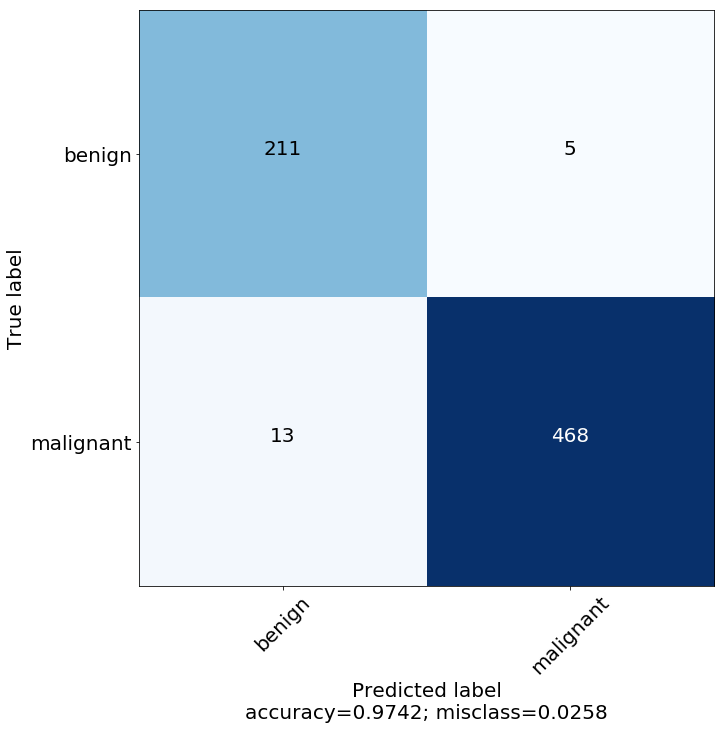

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[211   5]
 [ 13 468]]
              precision    recall  f1-score   support

      benign       0.94      0.98      0.96       216
   malignant       0.99      0.97      0.98       481

   micro avg       0.97      0.97      0.97       697
   macro avg       0.97      0.97      0.97       697
weighted avg       0.97      0.97      0.97       697



In [22]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  94.19642857142857
Specificity :  98.94291754756871


In [23]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9656967305949864


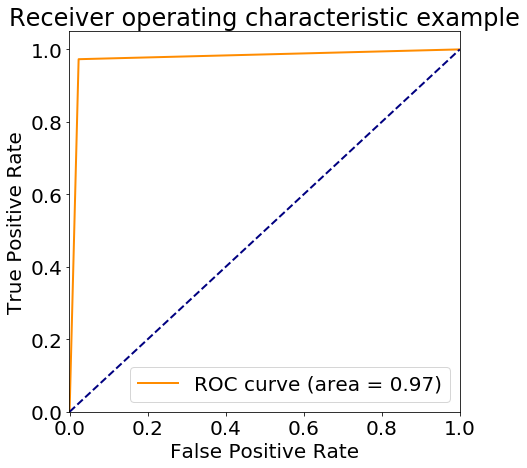

In [24]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

697/697 [==============================] - 0s 62us/step


In [26]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

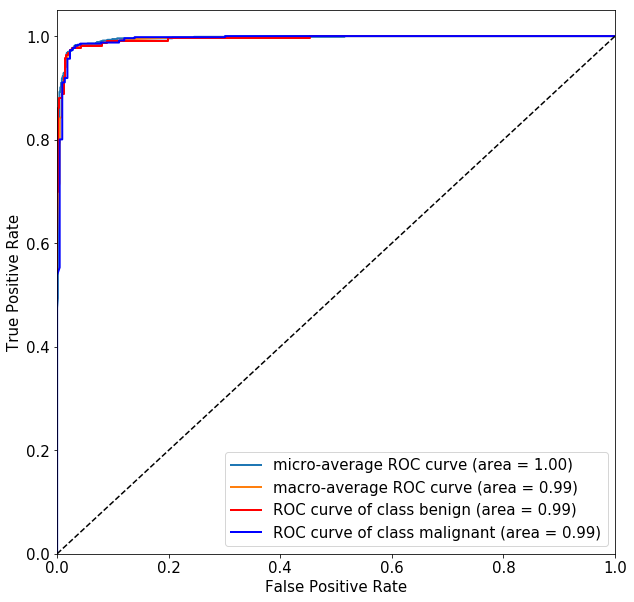

In [28]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
tn, fp, fn, tp = cm.ravel()

In [30]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.9741750358680057
Precision: 0.9894291754756871
Recall: 0.972972972972973
tp: 468
fp: 5
tn: 211
fn: 13


In [31]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.9811320754716982


In [32]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9811320754716982


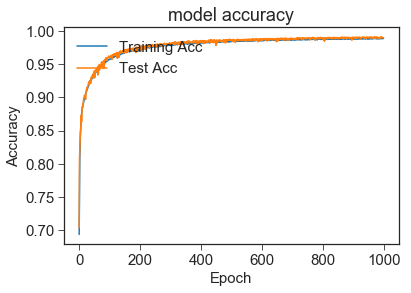

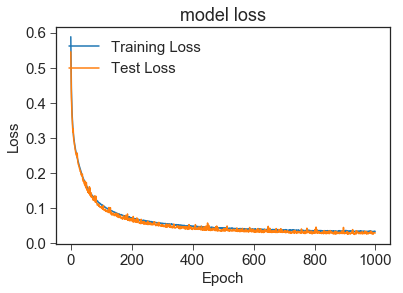

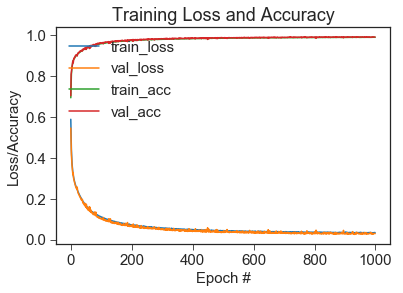

In [33]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")